/tmp/ipykernel_3547277/2661642647.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])


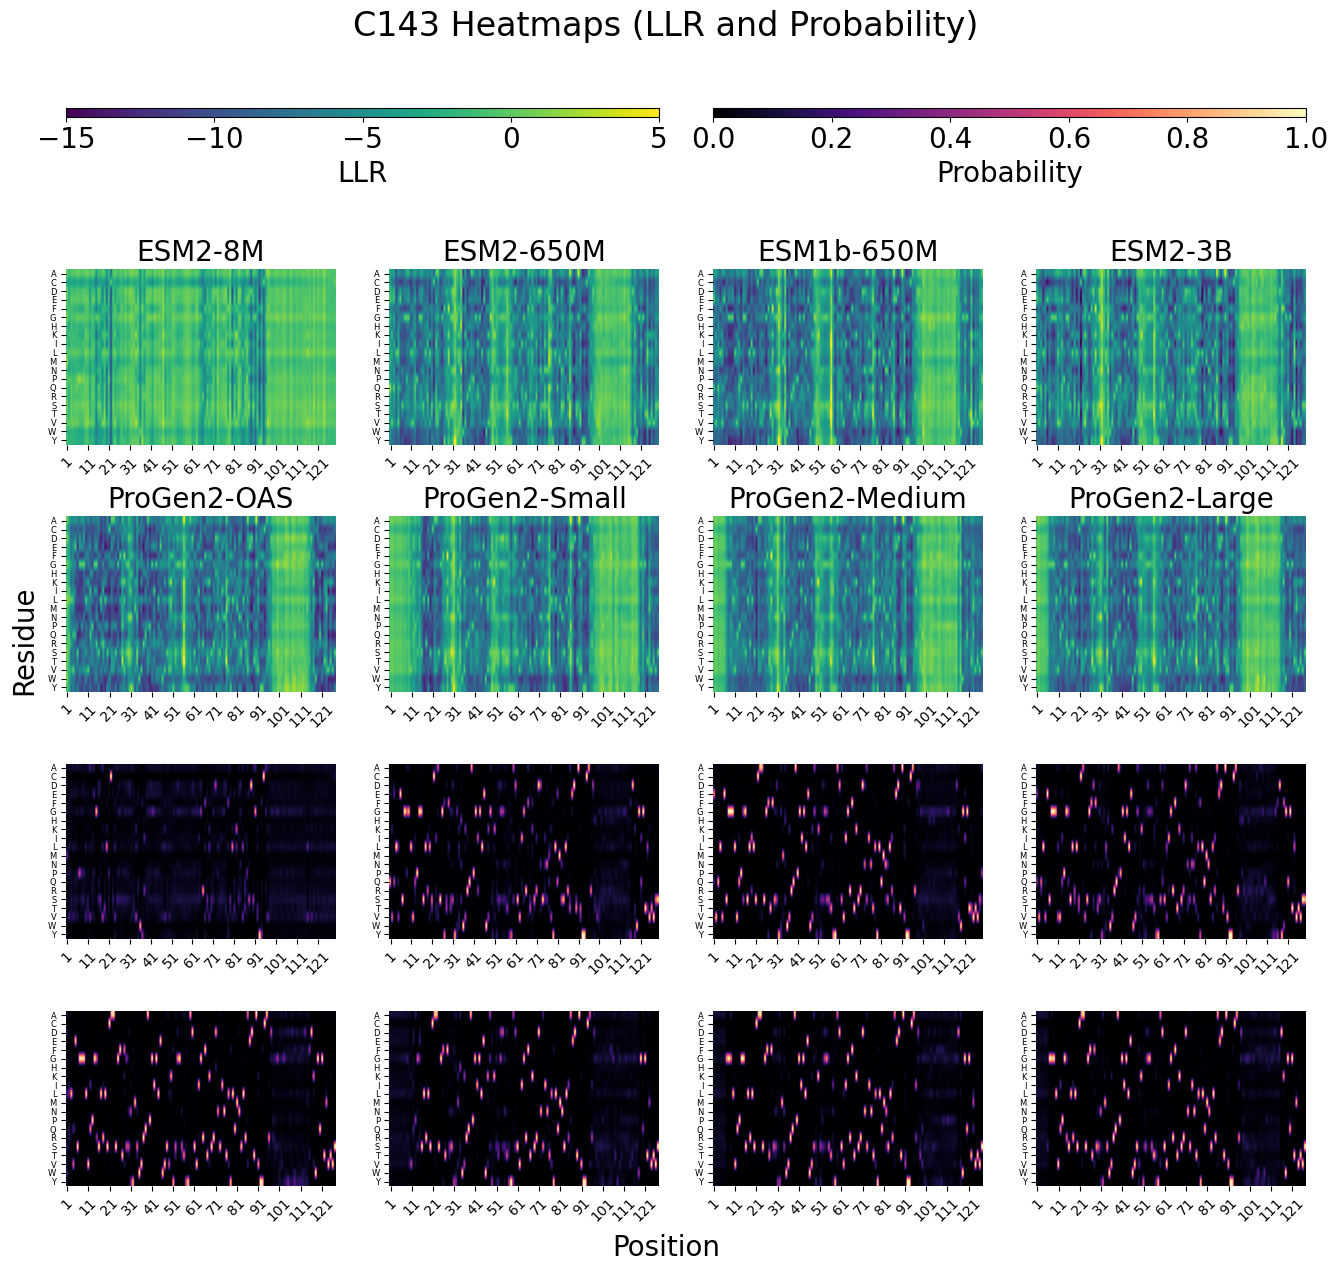

/tmp/ipykernel_3547277/2661642647.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])


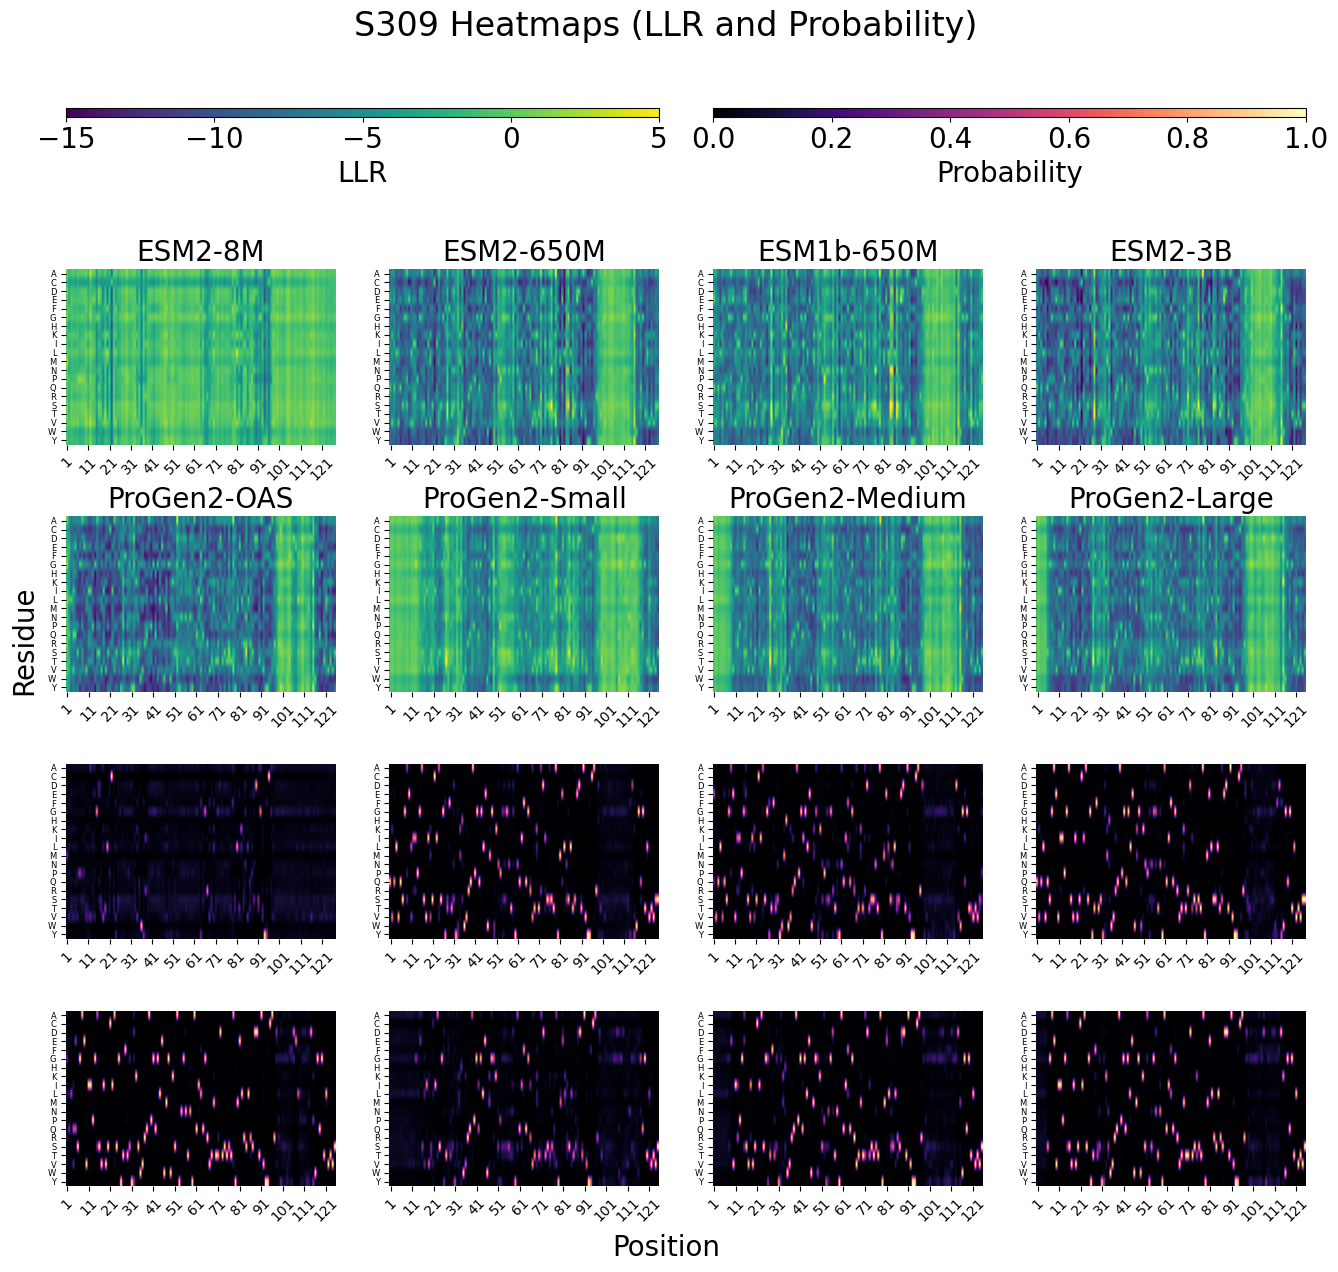

/tmp/ipykernel_3547277/2661642647.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])


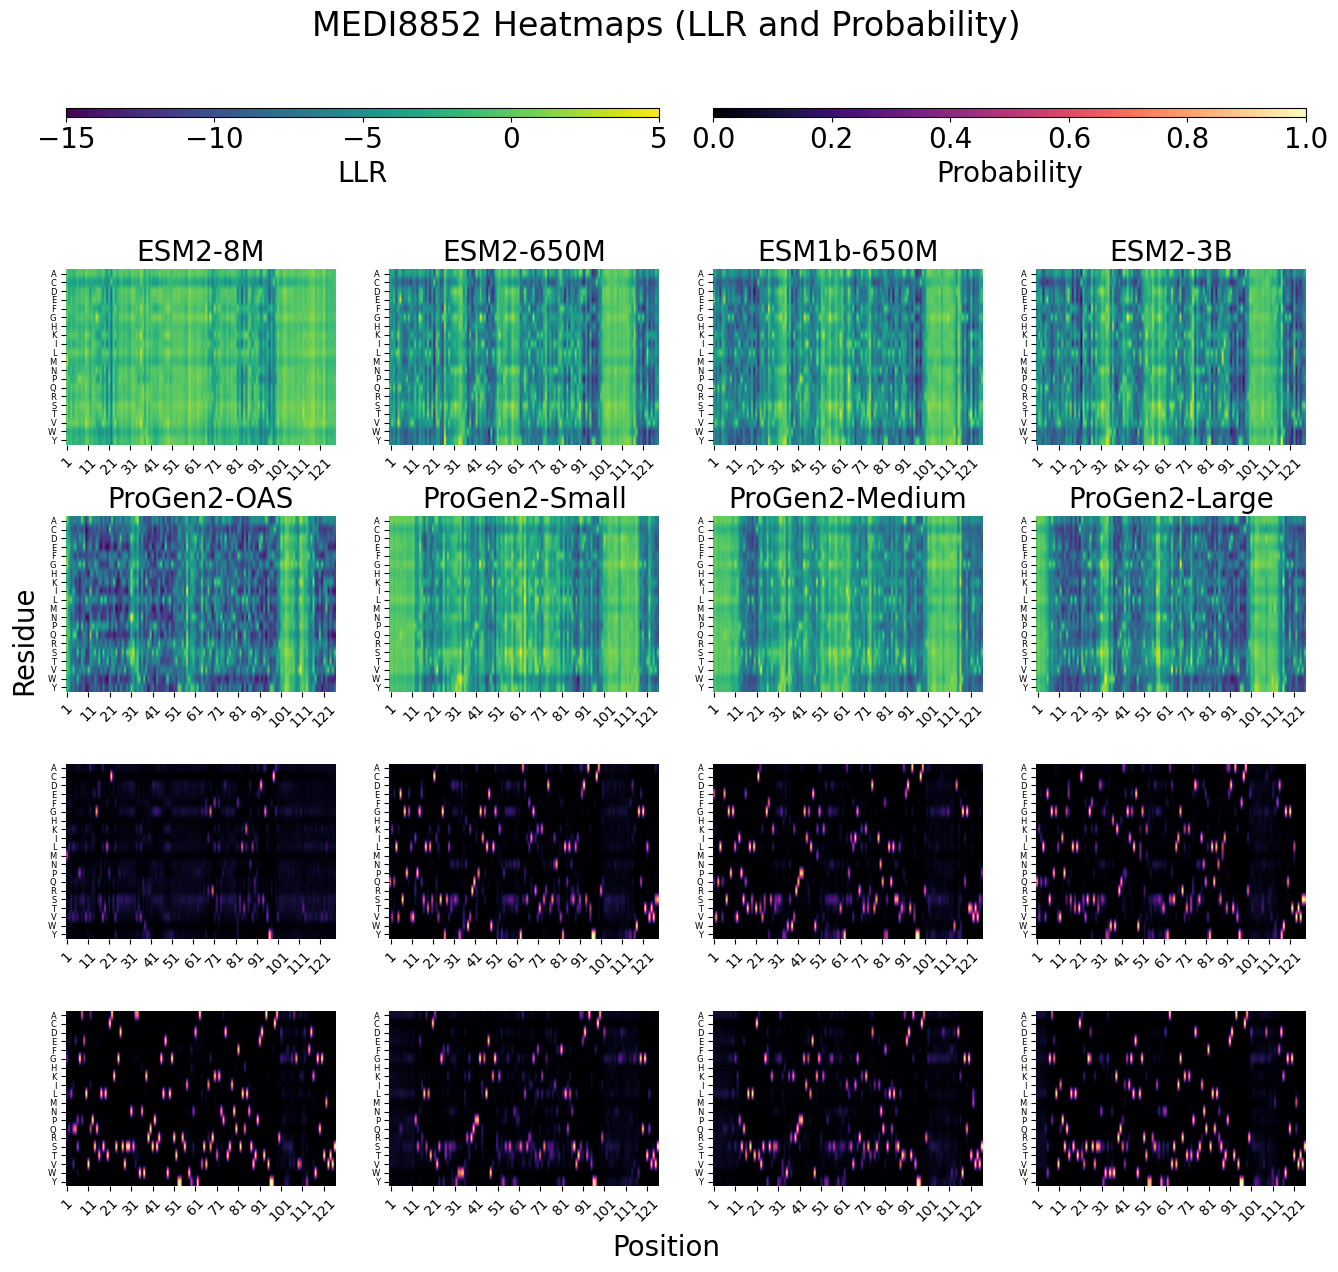

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# === CONFIGURATION ===
DATA_FOLDER = "."
OUTPUT_FOLDER = "plots"
ANTIBODIES = ["C143", "S309", "MEDI8852"]
RESIDUES = ["A", "C", "D", "E", "F", "G", "H", "K", "I", "L",
            "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
N_POSITIONS = 129
POSITIONS = np.arange(1, N_POSITIONS + 1)

ESM_VARIANTS = ["ESM2-8M", "ESM2-650M", "ESM1b-650M", "ESM2-3B"]
PROGEN2_VARIANTS = ["ProGen2-OAS", "ProGen2-Small", "ProGen2-Medium", "ProGen2-Large"]
ALL_VARIANTS = ESM_VARIANTS + PROGEN2_VARIANTS

# === FONT SIZE CONFIGURATION ===
GLOBAL_LABEL_FONT = 20
LOCAL_LABEL_FONT = 10
TITLE_FONT = 20
COLORBAR_FONT = 20
COLORBAR_TICK_FONT = 20
RESIDUE_LABEL_FONT = 6

# === RESIDUE LABEL SETTINGS ===
SHOW_RESIDUE_LABELS = True
INVERT_Y_AXIS = False

# === OUTPUT FOLDER CREATION ===
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# === HELPERS ===
def extract_model_variant(fname):
    if "facebook_esm2_t6_8M" in fname:
        return "ESM2-8M"
    elif "facebook_esm2_t33_650M" in fname:
        return "ESM2-650M"
    elif "facebook_esm1b_t33_650M" in fname:
        return "ESM1b-650M"
    elif "facebook_esm2_t36_3B" in fname:
        return "ESM2-3B"
    elif "progen2-oas" in fname:
        return "ProGen2-OAS"
    elif "progen2-small" in fname:
        return "ProGen2-Small"
    elif "progen2-medium" in fname:
        return "ProGen2-Medium"
    elif "progen2-large" in fname:
        return "ProGen2-Large"
    return None

def match_metric(fname):
    if "llr" in fname:
        return "llr"
    elif "probabilities" in fname:
        return "probabilities"
    return None

# === LOAD FILES ===
def load_all_heatmaps(DATA_FOLDER):
    data = {ab: {variant: {"llr": None, "probabilities": None} for variant in ALL_VARIANTS} for ab in ANTIBODIES}
    for fname in os.listdir(DATA_FOLDER):
        if not fname.endswith(".csv"):
            continue
        ab_match = next((ab for ab in ANTIBODIES if fname.startswith(ab)), None)
        model_variant = extract_model_variant(fname)
        metric = match_metric(fname)
        if ab_match and model_variant and metric:
            path = os.path.join(DATA_FOLDER, fname)
            df = pd.read_csv(path)
            df = df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")], errors="ignore")
            data[ab_match][model_variant][metric] = df.to_numpy()
    return data

# === PLOTTING FUNCTION ===
def plot_antibody_grid(antibody_data, antibody_name):
    fig = plt.figure(figsize=(16, 14))
    gs = gridspec.GridSpec(6, 4, height_ratios=[0.05, 0.05, 1, 1, 1, 1], hspace=0.6, wspace=0.2)

    axes_llr = []
    axes_prob = []

    # Colorbars (row 0)
    cax_llr = fig.add_subplot(gs[0, 0:2])
    cax_prob = fig.add_subplot(gs[0, 2:4])

    # Top 2 rows = LLR
    for idx, variant in enumerate(ALL_VARIANTS):
        row = (idx // 4) + 2
        col = idx % 4
        ax = fig.add_subplot(gs[row, col])
        data = antibody_data[variant]["llr"]
        if data is not None:
            im = ax.imshow(data, aspect="auto", cmap="viridis", vmin=-15, vmax=5)
            xt = np.arange(0, N_POSITIONS, 10)
            yt = np.arange(len(RESIDUES))
            ax.set_xticks(xt)
            ax.set_xticklabels(POSITIONS[xt], rotation=45, fontsize=LOCAL_LABEL_FONT)
            if SHOW_RESIDUE_LABELS:
                ax.set_yticks(yt)
                ax.set_yticklabels(RESIDUES, fontsize=RESIDUE_LABEL_FONT)
            else:
                ax.set_yticks([])
                ax.set_yticklabels([])
            if INVERT_Y_AXIS:
                ax.invert_yaxis()
            ax.set_title(variant, fontsize=TITLE_FONT)
            for spine in ax.spines.values():
                spine.set_visible(False)
            axes_llr.append(im)

    # Bottom 2 rows = Probability
    for idx, variant in enumerate(ALL_VARIANTS):
        row = (idx // 4) + 4
        col = idx % 4
        ax = fig.add_subplot(gs[row, col])
        data = antibody_data[variant]["probabilities"]
        if data is not None:
            im = ax.imshow(data, aspect="auto", cmap="magma", vmin=0, vmax=1)
            xt = np.arange(0, N_POSITIONS, 10)
            yt = np.arange(len(RESIDUES))
            ax.set_xticks(xt)
            ax.set_xticklabels(POSITIONS[xt], rotation=45, fontsize=LOCAL_LABEL_FONT)
            if SHOW_RESIDUE_LABELS:
                ax.set_yticks(yt)
                ax.set_yticklabels(RESIDUES, fontsize=RESIDUE_LABEL_FONT)
            else:
                ax.set_yticks([])
                ax.set_yticklabels([])
            if INVERT_Y_AXIS:
                ax.invert_yaxis()
            for spine in ax.spines.values():
                spine.set_visible(False)
            axes_prob.append(im)

    # Apply colorbars
    cb_llr = fig.colorbar(axes_llr[0], cax=cax_llr, orientation="horizontal")
    cb_llr.set_label("LLR", fontsize=COLORBAR_FONT)
    cb_llr.ax.tick_params(labelsize=COLORBAR_TICK_FONT)

    cb_prob = fig.colorbar(axes_prob[0], cax=cax_prob, orientation="horizontal")
    cb_prob.set_label("Probability", fontsize=COLORBAR_FONT)
    cb_prob.ax.tick_params(labelsize=COLORBAR_TICK_FONT)

    fig.suptitle(f"{antibody_name} Heatmaps (LLR and Probability)", fontsize=GLOBAL_LABEL_FONT + 4, y=0.95)
    fig.text(0.5, 0.06, "Position", ha="center", fontsize=GLOBAL_LABEL_FONT)
    fig.text(0.09, 0.5, "Residue", va="center", rotation="vertical", fontsize=GLOBAL_LABEL_FONT)
    plt.tight_layout(rect=[0.04, 0.04, 1, 0.98])

    output_path_pdf = os.path.join(OUTPUT_FOLDER, f"{antibody_name}_heatmaps.pdf")
    plt.savefig(output_path_pdf, bbox_inches="tight")
    plt.show()

# === LOAD AND PLOT EVERYTHING ===
all_data = load_all_heatmaps("./Antibody_LLR_CSVs/")

for antibody in ANTIBODIES:
    plot_antibody_grid(all_data[antibody], antibody)

